Instalación de matplotlib2tikz

In [3]:
!pip3 install matplotlib2tikz

**Conexión con el google colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/DatasetRNN/names/"
rootDir = "/content/drive/My Drive/DatasetRNN/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


Importación de Librerías

In [4]:
#unicode to ASCII conversion
from __future__ import unicode_literals, print_function, division

#Import necessary packages, torch, numpy, pylab
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
import random
import torch.nn as nn
import matplotlib.ticker as ticker
#open files
from io import open
#global path
import glob
#Operating system calls
import os
#unicode manipulation
import unicodedata
#string manipulation
import string
import math
import matplotlib2tikz

/usr/local/lib/python3.6/dist-packages/matplotlib2tikz/__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


Creación y Utilidades del Dataset

In [0]:
allSamples = []
allTargets = {}

"""
Get list of all the files complying the regular expression in path
@param path
"""
def findFiles(path): return glob.glob(path)

"""
Convert all characters from unicode to ascii
Many languages use additional special characters, which need to be standarized
for instance Ślusàrski goes to Slusarski
@param inputString
"""
def convertUnicodeToAscii(inputString):
    #normalize the input string using the Normal form decomposed standard (an additional character for accents)
    normalizedString = unicodedata.normalize('NFD', inputString)

    #creates the ascii string by discarding the marking non space characters (Mn)
    return ''.join(
        character for character in normalizedString
        if unicodedata.category(character) != 'Mn'
        and character in arrayAllLeters
    )

"""
Read a file and split into lines
"""
def readLinesAscii(filename):
    #read the lines and create an array of lines
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    #to ascii
    return [convertUnicodeToAscii(line) for line in lines]


"""
Create the dataset, assuming one file per language
@param inputFiles, path and extension of the input files

"""
def createDataset(inputFiles):
    # Build the  dictionary of category to lines, in this case a list of names per language
    categoryToLines = {}
    allCategories = []
    numberOfCategories = 0
    files = findFiles(inputFiles);
    for fileName in files:
        #the category in this case corresponds to the language, name of the file
        category = os.path.splitext(os.path.basename(fileName))[0]
        #append in the array of categories
        allCategories.append(category)
        #read all the lines in the file of that language (category)
        lines = readLinesAscii(fileName)
        for line in lines:
            allSamples.append(line)
            allTargets[line] = category
        #add the entry in the dictionary
        categoryToLines[category] = lines
    random.shuffle(allSamples)
    random.shuffle(allSamples)
    numberOfCategories = len(allCategories)
    return (categoryToLines, allCategories, numberOfCategories);


""" 
Find letter index from all_letters, e.g. "a" = 0 
@param letter, letter to index
"""
def convertLetterToIndex(letter):
    return arrayAllLeters.find(letter)

""" 
Turn a line into a tensor of dimensions <lineLength x 1 x numberOflettersAscii>
@param line
""" ,
def convertLineToTensor(line):
    tensor = torch.zeros(len(line), 1, numberOfLettersAscii)
    #for each character , convert it to a one hot vector of length numberOflettersAscii
    for characterPos, letter in enumerate(line):
        tensor[characterPos][0][convertLetterToIndex(letter)] = 1
    return tensor
"""
Get the category with the hightest probability in the output layer
@param output, array of the output from the output units
"""
def getCategoryFromOutput(output, allCategories):
    _, topUnit = output.topk(1)
    highestCategory = topUnit[0].item()
    return allCategories[highestCategory], highestCategory

"""
Takes a random sample from array
@param array to take sample from
@return random sample from array
"""
def takeRandomChoice(array):
    randomChoice = array[random.randint(0, len(array) - 1)]
    #print("Len array take random choice", randomChoice), for instance category chinese
    return randomChoice

"""
Take random training sample from categoryToLines dictionary
@return both line and category in ascii and in tensor
"""
def takeRandomTrainingExample(allCategories, categoryToLines):
    category = takeRandomChoice(allCategories)
    line = takeRandomChoice(categoryToLines[category])
    categoryTensor = torch.tensor([allCategories.index(category)], dtype = torch.long)
    lineTensor = convertLineToTensor(line)
    return category, line, categoryTensor, lineTensor
  
"""
Take shuffled training sample from allSamples dictionary
@return both line and category in ascii and in tensor
"""
def takeShuffledTrainingExample(index, allCategories):
    index = index % len(allSamples)
    if index == 0:
      random.shuffle(allSamples)
      random.shuffle(allSamples)
    line = allSamples[index]
    category = allTargets[line]
    categoryTensor = torch.tensor([allCategories.index(category)], dtype = torch.long)
    lineTensor = convertLineToTensor(line)
    return category, line, categoryTensor, lineTensor
  
  
#array of all the letters with some punctuations
arrayAllLeters = string.ascii_letters + " .,;'"
#total number of letters
numberOfLettersAscii = len(arrayAllLeters)

Red para Estimación de Idioma Original

In [0]:
"""
Recurrent Neural Network class, using Elman layout
"""
class RecurrentNeuralNet(nn.Module):
    """
    Constructor module
    @param inputSize, number of input units (per time unit)
    @param hiddenSize, number of hidden units
    @param outputSize, number of output units (classes)
    """
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RecurrentNeuralNet, self).__init__()

        self.hiddenSize = hiddenSize
        #Applies a linear transformation to the incoming data: y = xA^T + b
        self.pHidden = nn.Linear(inputSize + hiddenSize, hiddenSize)
        self.pOutput = nn.Linear(inputSize + hiddenSize, outputSize)
        self.softmax = nn.LogSoftmax(dim = 1)
    """
    Forward pass
    @param input, input time bucket
    @param contextOutput, output of the hidden layer for t - 1 (previous time bucket)
    @return output and hidden layer output
    """
    def forward(self, input, contextOutput):
        combined = torch.cat((input, contextOutput), 1)
        #hidden output is not connected to the output layer in the same time step
        hidden = self.pHidden(combined)
        output = self.pOutput(combined)
        output = self.softmax(output)
        return output, hidden
    """
    Init hidden output
    """
    def initHidden(self):
        return torch.zeros(1, self.hiddenSize)
      
"""
Train function, to estimate parameters
@categoryTensor, category of the sample, in tensor format
@param lineTensor, name or word to classify
@param recurrentNeuralNet, instance of the Recurrent Neural Net class
@param criterion, loss function to optimize
"""
def trainWithOneLine(categoryTensor, lineTensor, recurrentNeuralNet, criterion):
    contextOutput = recurrentNeuralNet.initHidden()

    recurrentNeuralNet.zero_grad()
    #a line is a sample, one name?
    for i in range(lineTensor.size()[0]):
      
        output, contextOutput = recurrentNeuralNet(lineTensor[i], contextOutput)
    #only the last output is used... WRONG!_?
    loss = criterion(output, categoryTensor)
    #propagate gradient backwards
    loss.backward()
    #parameters.grad.data will contain gradient info
    # Add parameters' gradients to their values, multiplied by learning rate
    for parameters in recurrentNeuralNet.parameters():
        parameters.data.add_(-learning_rate, parameters.grad.data)
        parameters.grad.data.zero_()

    return output, loss.item()

Red para la Estimación de Idioma Modificada

Entrenamiento

Starting run #1:
5000 50%  2.8191 Grulich / Scottish ✗ (Czech)
10000 100%  2.8330 Caron / Scottish ✗ (French)


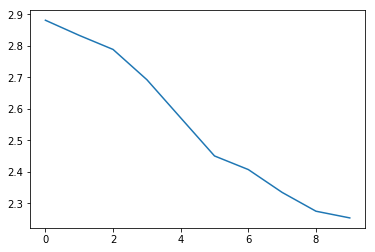

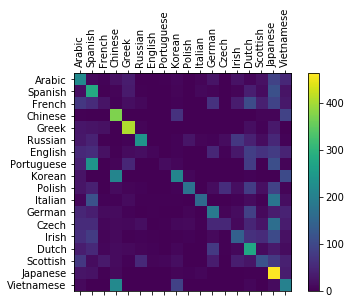

Finished run #1

Done


In [8]:


# Archivos para Red Modificada con Balanceo de Datos
allConfMatFile = rootDir + 'modifiedBalAllConfMat2.npy';
imagesPrefix = rootDir + '/img/MB2'

# USE THIS CONFIG TO TRAIN WITH ORIGINAL DATASET
inputDataset = rootDir + 'names/*.txt';
#randomSample = True

# USE THIS CONFIG TO TRAIN WITH BALANCED DATASET
#inputDataset = rootDir + 'namesB/*.txt';
randomSample = True


#number of iterations to train model, one iteration per line (name)
numberIters = 10000

#print every X iterations
printEvery = 5000
plotEvery = 1000

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

silent = False
allConfMat = [];
runs = 1

"""
Train model with entire dataset
@param numberIterations for training (one sample per iteration)
@param recurrenNeuralNet, RNN to train
@param criterion, loss function to optimize
@param allCateogories, number of classes
@param categoryToLines, dataset, dictionary with one entry per class
"""
def trainWithDataSet(numberIterations, recurrentNeuralNet, criterion, allCategories, categoryToLines):
    # Current and all losses plot
    currentLoss = 0
    allLosses = []
    for iteration in range(1, numberIterations + 1):
        #takes one line (name) sample randomly
        if randomSample:
          category, line, categoryTensor, lineTensor = takeRandomTrainingExample(allCategories, categoryToLines)
        else:
          category, line, categoryTensor, lineTensor = takeShuffledTrainingExample(iteration, allCategories)
        output, loss = trainWithOneLine(categoryTensor, lineTensor, recurrentNeuralNet, criterion)
        currentLoss += loss
        # Print iteration number, loss, name and guess, every N number of iterations
        if iteration % printEvery == 0 and not silent:
            guess, _ = getCategoryFromOutput(output, allCategories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%%  %.4f %s / %s %s' % (
            iteration, iteration / numberIterations * 100, loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iteration % plotEvery == 0:
            allLosses.append(currentLoss / plotEvery)
            currentLoss = 0
    return (allLosses, recurrentNeuralNet)

"""
Evaluate a sample in the model
@param lineTensor, sample to evaluate
@param recurrentNeuralNet, model to use
"""
def evaluateSample(lineTensor, recurrentNeuralNet):
    contextOutput = recurrentNeuralNet.initHidden()

    for i in range(lineTensor.size()[0]):
        output, contextOutput = recurrentNeuralNet(lineTensor[i], contextOutput)

    return output

"""
Evaluate the model and calculate the confusion matrix
@param
"""
def evaluateModel(numberCategories, recurrentNeuralNet, allCategories, categoryToLines):
    # Confusion matrix <numberCategories x numberCategories>
    confusionMatrix = torch.zeros(numberCategories, numberCategories)
    numSamplesEvaluation = 10000
    # Go through a bunch of examples and record which are correctly guessed
    for i in range(numSamplesEvaluation):
        category, line, categoryTensor, lineTensor = takeRandomTrainingExample(allCategories, categoryToLines)
        output = evaluateSample(lineTensor, recurrentNeuralNet)
        _, guessI = getCategoryFromOutput(output, allCategories)
        categoryI = allCategories.index(category)
        confusionMatrix[categoryI][guessI] += 1
        
    # Normalize by dividing every row by its sum
    #for i in range(numberCategories):
    #    confusionMatrix[i] = confusionMatrix[i] / confusionMatrix[i].sum()

    # Convert to numpy
    confusionMatrix = confusionMatrix.numpy()
    
    #Add this confusion matrix to the global list
    allConfMat.append(confusionMatrix)
    
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusionMatrix)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + allCategories, rotation=90)
    ax.set_yticklabels([''] + allCategories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

def main():

    (categoryToLines, allCategories, numberOfCategories) = createDataset(inputDataset)

    #cross entropy criterion used
    criterion = nn.NLLLoss()
    numberHiddenUnits = 128
    
    for i in range(1, runs + 1):
      print("Starting run #%i:" % i)
      recurrentNeuralNet = RecurrentNeuralNet(numberOfLettersAscii, numberHiddenUnits, numberOfCategories)
      (allLosses, recurrentNeuralNet) = trainWithDataSet(numberIters, recurrentNeuralNet, criterion, allCategories, categoryToLines)
      plt.figure()
      plt.plot(allLosses)
      evaluateModel(numberOfCategories, recurrentNeuralNet, allCategories, categoryToLines)
      print("Finished run #%i\n" % i)

    #Save all confusion matrix
    np.array(allConfMat).dump(open(allConfMatFile, 'wb'))
    print("Done")
    
main()

Validación

*   Matriz de Confusión Promedio
*   Falsos Positivos
*   Falsos Negativos
*   Sensibilidad
*   Exhaustividad
*   F1-score
*   Promedio de Clases

F1
Exhaustividad media, precision media y F1 medio
[0.40550363, 0.35474518, 0.32722774]


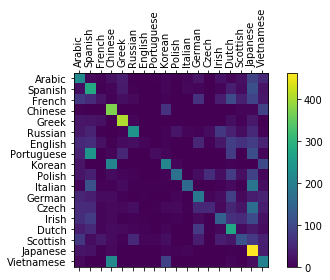

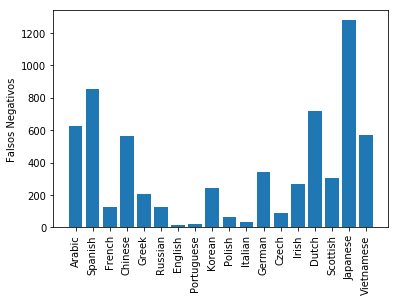

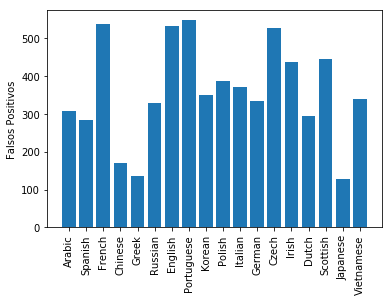

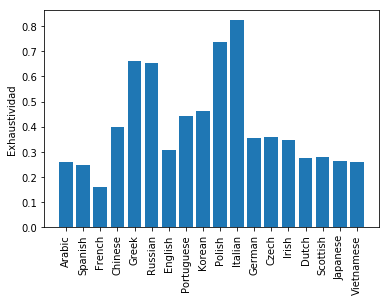

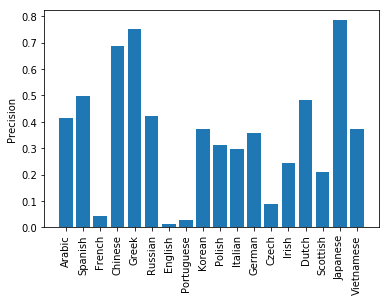

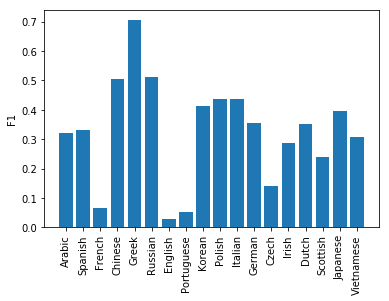

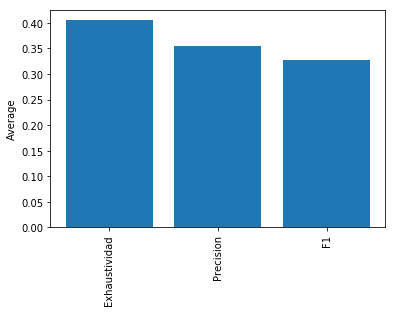

In [10]:



def saveAverageConfMat(cm):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + allCategories, rotation=90)
  ax.set_yticklabels([''] + allCategories)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.tight_layout()
  plt.savefig(imagesPrefix + 'ACM.png', dpi=150)
  
def saveBarGraph(score, title, labels):
  plt.figure()
  index = np.arange(len(labels))
  plt.bar(index, score)
  plt.ylabel(title)
  plt.xticks(index, labels, rotation=90)
  matplotlib2tikz.save(imagesPrefix + title.replace(" ", "").lower() + '.tex', figurewidth='\\textwidth * 0.6')
  

(categoryToLines, allCategories, numberOfCategories) = createDataset(inputDataset)
allConfMat = np.load(allConfMatFile, allow_pickle=True) 
cm = allConfMat.mean(axis=0)
averageScores = calculateAverageF1RecallPrecision(cm, allCategories)




saveBarGraph(averageScores[2:], 'Average', ['Exhaustividad', 'Precision', 'F1'])
print('Exhaustividad media, precision media y F1 medio')
print(averageScores[2:])
